In [1]:
using Revise, CSV, DataFrames, PyPlot, Interpolations, HDF5, Statistics, Korg, StaticArrays

# re-format and store profiles

In [23]:
@time index = CSV.read("../StehleHutchson1999-hydrogen-stark-broadening/params.dat", 
    header=["lower", "upper", "lambda0", "Kalpha", "ne", "E0", "temp", "R0_Debye", "filename"], 
    delim=' ', ignorerepeated=true, DataFrame);
;

  0.516072 seconds (663.49 k allocations: 40.652 MiB, 93.48% compilation time)


In [36]:
temps = Int.(sort(collect(Set(index.temp))))
;

In [276]:
using StaticArrays
function fterp(dir, temp, ne; siz=71)
    cd("/Users/aw/Dropbox/korg_files/StehleHutchson1999-hydrogen-stark-broadening/")
    
    if temp == 2500
        #hack because the fortran code rejects 2500 for some reason
        temp += 1e-10
    end
    
    run(`cp a.out $dir`)
    cd(dir)
    open("input", "w") do file
        write(file, "$(temp)\n$(ne)")
    end
    output = readchomp(pipeline(`cat input`, `./a.out`))
    cd("../..")

    table = CSV.File(codeunits(output), datarow=15, delim=' ', ignorerepeated=true, 
        header=["detuning", "delta_nu", "fdop", "fraw"])
    if size(table) == (0,)
        fill(NaN, 2, siz)
    else
        if siz != length(table.delta_nu)
            #println(siz, " ", length(table.delta_nu))
        end
        [table.delta_nu' ; table.fdop']
    end
end


fterp (generic function with 1 method)

In [102]:
fname = "Stehle-Hutchson-hydrogen-profiles.h5"
#rm("./Stehle-Hutchson-hydrogen-profiles.h5")
groups = groupby(index, [:upper, :lower])
sizes = map(collect(groups)) do group
    size(fterp(group.filename[2][1:7], group.temp[2], group.ne[2]), 2)
end
@time map(zip(collect(groups), sizes)) do (group, siz)
    figure()
    temps = sort(collect(Set(group.temp)))
    nes = sort(collect(Set(group.ne)))
    
    #scatter(group.temp, group.ne)
    #title("$(group.lower[1]) to $(group.upper[1])")
    #xscale("log")
    #yscale("log")
    
    A = fill(NaN, length(temps), length(nes), siz)
    L0 = fill(NaN, length(temps), length(nes))
    for (i, temp) in enumerate(temps), (j, ne) in enumerate(nes)
        rows = group[(group.temp .== temp) .& (group.ne .== ne), :]
        if size(rows, 1) == 1
            row = rows[1, :]
            A[i,j, :] .= fterp(row.filename[1:7], row.temp, row.ne; siz=siz)[2, :]
            L0[i,j] = row.lambda0
        end
    end
    
    row = group[1, :]
    Δνs = fterp(row.filename[1:7], row.temp, row.ne; siz=siz)[1, :]
    F0 = 1.25e-9 * row.ne^(2/3)
    
    h5open(fname, "cw") do fid
        transition = "$(group.lower[1])_$(group.upper[1])"
        println(transition)
        fid[transition*"/profile"] = A
        fid[transition*"/lambda0"] = L0
        fid[transition*"/electron_number_densities"] = nes
        fid[transition*"/delta_nu_over_F0"] = Δνs ./ F0
        fid[transition*"/temps"] = temps
        h5writeattr(fname, transition, Dict(
                "lower"=>group.lower[1], 
                "upper"=>group.upper[1]))
    end
end
;

1_2
1_3
2_3
1_4
2_4
3_4
1_5
2_5
3_5
1_6
2_6
3_6
1_7
2_7
3_7
1_8
2_8
3_8
1_9
2_9


sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3_9
1_10
2_10
3_10
1_11
2_11
3_11
1_12
2_12
3_12
1_13
2_13
3_13
1_14
2_14
3_14
1_15
2_15
3_15
1_16
2_16
3_16
1_17
2_17
3_17
1_18
2_18
3_18
1_19
2_19
3_19
1_20
2_20
3_20
1_21
2_21
3_21
1_22
2_22
3_22
1_23
2_23
3_23
1_24
2_24
3_24
1_25
2_25
3_25
1_26
2_26
3_26
1_27
2_27
3_27
1_28
2_28
3_28
1_29
2_29
3_29
1_30
2_30
3_30
612.077375 seconds (46.56 M allocations: 3.796 GiB, 0.28% gc time, 0.03% compilation time)


### add $K_\omega$ and $log~gf~$  to the HDF5 file

In [41]:
Hlines = CSV.read("../linelists/Hlines.vald", DataFrame, skipto=3, footerskip=3,
    header=[:spec, :wl, :E, :log_gf, :rad, :stark, :vdW])
;

┌ Warning: thread = 1 warning: parsed expected 7 columns, but didn't reach end of line around data row: 3. Ignoring any extra columns on this row
└ @ CSV /Users/aw/.julia/packages/CSV/Zl2ww/src/file.jl:613
┌ Warning: thread = 1 warning: parsed expected 7 columns, but didn't reach end of line around data row: 4. Ignoring any extra columns on this row
└ @ CSV /Users/aw/.julia/packages/CSV/Zl2ww/src/file.jl:613
┌ Warning: thread = 1 warning: parsed expected 7 columns, but didn't reach end of line around data row: 5. Ignoring any extra columns on this row
└ @ CSV /Users/aw/.julia/packages/CSV/Zl2ww/src/file.jl:613
┌ Warning: thread = 1 warning: parsed expected 7 columns, but didn't reach end of line around data row: 6. Ignoring any extra columns on this row
└ @ CSV /Users/aw/.julia/packages/CSV/Zl2ww/src/file.jl:613
┌ Warning: thread = 1 warning: parsed expected 7 columns, but didn't reach end of line around data row: 7. Ignoring any extra columns on this row
└ @ CSV /Users/aw/.julia/packa

In [46]:
?h5writeattr

search: h5writeattr



No documentation found.

`HDF5.h5writeattr` is a `Function`.

```
# 1 method for generic function "h5writeattr":
[1] h5writeattr(filename, name::AbstractString, data::Dict) in HDF5 at /Users/aw/.julia/packages/HDF5/0iEnL/src/HDF5.jl:526
```


In [55]:
#this will fail if the attribute are already defined.

cd("/Users/aw/Dropbox/korg_files/StehleHutchson1999-hydrogen-stark-broadening/")
fname = "Stehle-Hutchson-hydrogen-profiles.h5"
h5open(fname, "r+") do fid
    for key in keys(fid)
        i = findfirst(eachrow(index)) do row
            row.lower == HDF5.read_attribute(fid[key], "lower")
            row.upper == HDF5.read_attribute(fid[key], "upper")
        end
        K = index[i, "Kalpha"]
        
        lambda0 = read(fid[key], "lambda0")[1]
        j = argmin(abs.([line.wl for line in eachrow(Hlines)] .- lambda0))
        #println("λ₀ = $(lambda0), Δλ = $(Hlines.wl[j] - lambda0)")
        delete_attribute(fid[key], "log_gf")
        attributes(fid[key])["log_gf"] = Hlines.log_gf[j]
        
        #h5writeattr(fname, key, Dict("Kalpha"=>K, "log_gf"=>Hlines.log_gf[j]))
    end
end

920.97
919.36
918.14
917.19
916.44
915.83
915.34
914.93
914.59
914.3
1215.68
914.05
913.84
913.65
913.49
913.35
913.22
913.11
913.02
912.93
912.85
1025.73
912.78
972.55
949.75
937.81
930.76
926.24
923.16
3799.01
3771.74
3751.25
3735.47
3723.03
3713.06
3704.94
3698.24
3692.64
3687.92
3683.89
3680.44
3677.45
3674.84
3672.56
3670.54
3668.76
3667.18
3665.76
3664.48
6564.7
3663.33
4862.74
4341.73
4102.94
3971.24
3890.19
3836.51
9017.44
8865.27
8752.93
8667.45
8600.81
8547.78
8504.87
8469.63
8440.32
8415.68
8394.75
8376.83
8361.35
8347.89
8336.12
8325.76
8316.59
8308.44
8301.16
8294.64
8288.76
18756.27
12821.67
10941.16
10052.1
9548.65
9231.6


# load and use profiles

# normalization

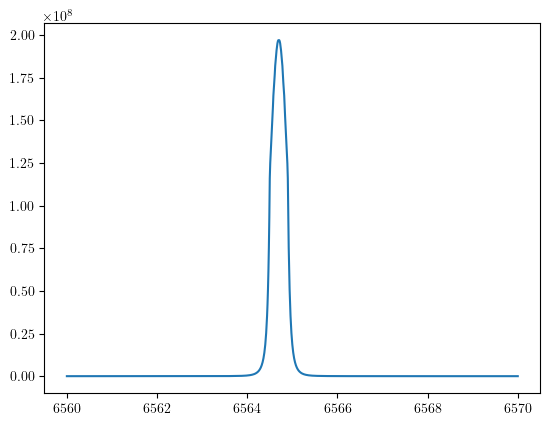

  0.144649 seconds (387.00 k allocations: 21.482 MiB, 99.54% compilation time)


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15e80ab20>

In [427]:
wls = (6560:0.01:6570) .* 1e-8
@time αs = hydrogen_line_absorption(wls, 10000.0, 1e13)
plot(wls*1e8, αs)

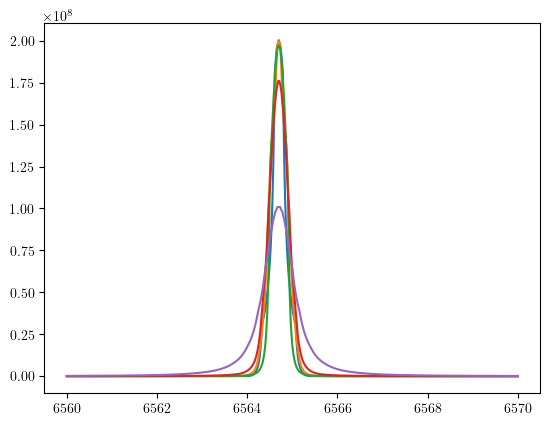

0.7754262404380845
0.9181224996326923
0.8036682858512334
0.9609765380234183
0.9730780953614736


In [428]:
wls = (6560:0.01:6570) .* 1e-8 
for ne in 10 .^ (11:15)
    αs = hydrogen_line_absorption(wls, 10_000.0, ne)
    plot(wls * 1e8, αs)
    println(Korg.trapezoid_rule(wls, αs))
end

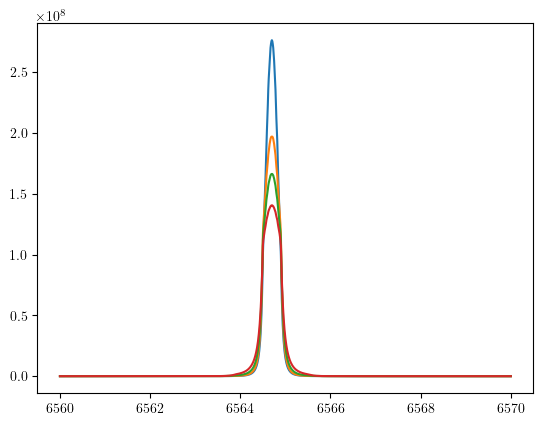

1.8282424544647157e-5
0.9286975449901336
1.7209540198708662e-5
0.8036682858512334
1.687460133430959e-5
0.7480970068816706
1.655325426443396e-5
0.7188793779850554


In [314]:
wls = (6560:0.01:6570) .* 1e-8
for T in [5000, 10_000, 15_000, 20_000]
    αs = hydrogen_line_absorption(wls, T, 1e13)
    println(αs[1])
    plot(wls * 1e8, αs)
    println(Korg.trapezoid_rule(wls, αs))
end

# this is slow

In [56]:
retry(Korg)

#70 (generic function with 1 method)

In [411]:
using StatProfilerHTML

In [11]:
wls = (3000:0.01:16000) .* 1e-8
@time αs = hydrogen_line_absorption(wls, 10000.0, 1e13)
@profilehtml αs = hydrogen_line_absorption(wls, 10000.0, 1e13)
#xlim(6560, 6570)
plot(wls*1e8, αs)
yscale("log")

LoadError: UndefVarError: hydrogen_line_absorption not defined

# compare to fortran code output

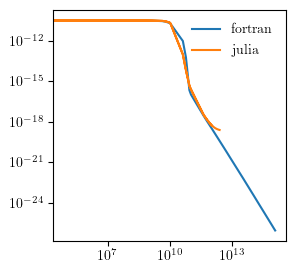

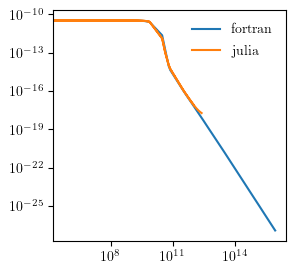

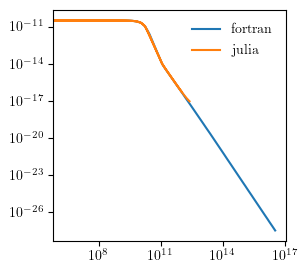

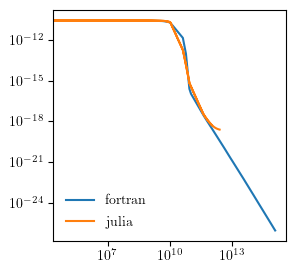

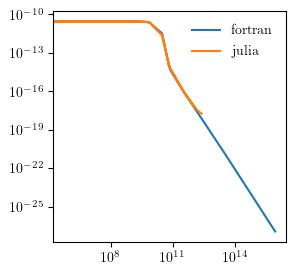

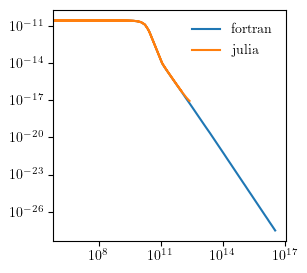

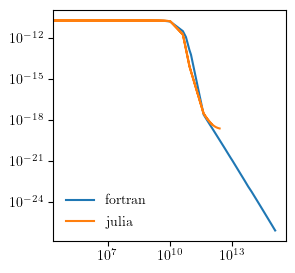

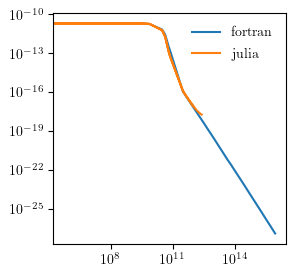

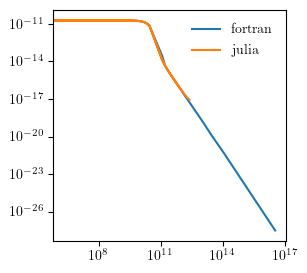

In [414]:
for T in [8003.4, 10000, 24321], ne in [2e11, 4e12, 3e13]
    figure(figsize=(3,3))
    
    P = fterp("ba/ba03/", T, ne)
    plot(P[1, :], P[2, :], label="fortran")
    xscale("log")
    yscale("log")

    wls = (6550:0.01:6600) .* 1e-8
    αs = hydrogen_line_absorption(wls, T, ne)
    nus = Korg.c_cgs ./ wls
    dλdν = wls.^2 ./ Korg.c_cgs
    plot(abs.(nus .- (Korg.c_cgs / (6564.7*1e-8))), αs .* dλdν, label="julia")

    legend()
end

# save profile for Korg tests

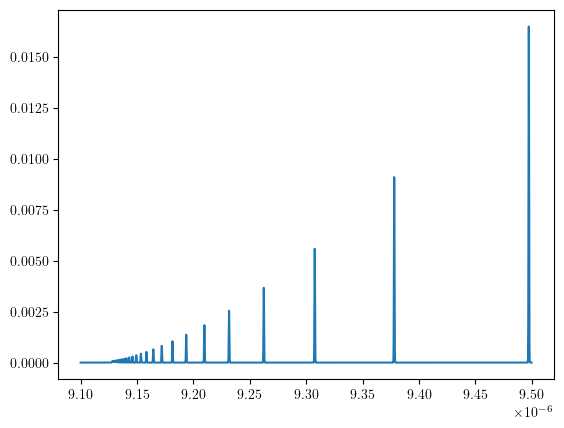

  0.007254 seconds (561 allocations: 1.537 MiB)


In [3]:
#wls = (1020:0.01:1032) .* 1e-8
wls = (910:0.01:950) .* 1e-8
@time αs = Korg.hydrogen_line_absorption(wls, 9000.0, 1e11, 1e13, Korg.partition_funcs[Korg.literals.H_I], 
    Korg.hline_stark_profiles, 0.0)
plot(wls, αs)

fname = "lyman_absorption.h5"
h5write(fname, "profile", αs)
h5writeattr(fname, "profile", Dict("start_wl"=>910*1e-8, "stop_wl"=>950*1e-8, "wl_step"=>0.01*1e-8, "T"=>9000.0, 
        "ne"=>1e11, "nH_I"=>1e13))